# Regression Analysis of Sabin data 

This analsys has been done in order to try and determine the context effects
of different context on the substitution probability
The input data is a csv files of the different K-mers and the $log[Pr(A\to B|S]$ of substitution rates of each of the passeges.

It includes 5 stages:

1. Feature extraction- creating a dummy variable for the categorical feature of context in a certain position
2. Feature selection- selecting the most important features using the randomized lasso regression method
3. Signifcance and effect test- after constructing the regression formula we are applying it in the regression to see if the effect of the motiff is significant also find the $\beta$ coeffs 

4. summarize the results across the different mutation types and passeges
5. Motif analysis - mining and displaying data about the different motifs to support decision about biological meaning of the motifs


In [274]:

import pandas as pd
import itertools
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from treeinterpreter import treeinterpreter as ti
from scipy.stats import kendalltau,spearmanr
import statsmodels.formula.api as sm
from sklearn.linear_model import RandomizedLasso
import os
import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
global MUTATIONS
MUTATIONS=['AC', 'GT', 'AG', 'CA', 'CG', 'GC', 'AT', 'GA', 'TG', 'CT', 'TC', 'TA']
global NUCS
NUCS=['A','C','G','T']
plt.style.use('ggplot')
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.Seq import reverse_complement, transcribe, back_transcribe, translate
from Bio import SeqIO
from scipy.stats import hypergeom


Sample of a data file in Passege 7

In [246]:
data=pd.read_csv(r'C:\Users\Guyling1\ContextProject\regressionCSVOneFileSABINK5P7.csv')
data.head(3)

,kmer,mutationType,P1,P2,P3,P4,P5,prob,createCpG
0,ACTAA,CT,A,C,C,A,A,-7.819754,False
1,TTATC,TA,T,T,T,T,C,-20.723266,False
2,ATAGG,GA,A,T,G,G,G,-20.723266,False


## 1.Feature Extraction

Defined a function that adds dummy variables of context dependence up to 3rd degree 


In [247]:
def generateFeature(k):
    for j in range(1,k+1):
        for feature in itertools.imap(''.join,itertools.combinations('1245',j)):
            yield feature

def functionGenerator(positions,x):
    res=''
    for position in positions:
        res+=x['P{}'.format(position)]
    return res

def createFeaturePrefix(featureList):
    res=''
    for feature in featureList:
        res+="P{}_".format(feature)
    return res

def getDummyVarPositionForK(data,k):
    for feature in generateFeature(k):
        featureList=[int(x) for x in list(feature)]
        concatFeature=data.apply(lambda x: functionGenerator(featureList,x),axis=1)
        dummies=pd.get_dummies(concatFeature,prefix=createFeaturePrefix(featureList))
        #print createFeaturePrefix(featureList) 
        data=pd.concat([data,dummies],axis=1)
    return data

def cleanDataMatrix(data,withNull=False):
    for i in range(1,6):
        data=data.drop('P{}'.format(i),axis=1)
    data=data.drop('createCpG',axis=1)
    if not(withNull):
        data=data[data['prob']>-20]
    return data

Sample of the data after adding the dummy var features

In [248]:
data=getDummyVarPositionForK(data,3)
data=cleanDataMatrix(data)
data.head(3)

,kmer,mutationType,prob,P1__A,P1__C,P1__G,P1__T,P2__A,P2__C,P2__G,...,P2_P4_P5__TCG,P2_P4_P5__TCT,P2_P4_P5__TGA,P2_P4_P5__TGC,P2_P4_P5__TGG,P2_P4_P5__TGT,P2_P4_P5__TTA,P2_P4_P5__TTC,P2_P4_P5__TTG,P2_P4_P5__TTT
0,ACTAA,CT,-7.819754,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,GCACT,TA,-10.486637,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,TTTAT,CT,-8.627929,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After adding the dummy variables we want to create a feature matrix $X$ and predicted value vector $\bar{y}$  so that we can easily use it in the regression .

WithNull parameter chooses if we want to include unobserved mutations with their defult value of $10^{-9}$


In [249]:

def createCovarsAndProbVectorForMutationType(data,mutType):
    data=data[data['mutationType']==mutType]
    probVector=data.prob
    covars=data.drop('prob',axis=1).drop('kmer',axis=1).drop('mutationType',axis=1)
    return covars,probVector,data

## 2.Feature Selection

Because we have a very large number of features and these features are also dependent (for example there is an obvious dependecy between P1=A and P1=A,P2=C) we use <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RandomizedLasso.html">Randomized lasso regression</a> which a randomized  $L-1$ norm based method of regression. We will only take in to account features that were used in over $ratio=0.2$ of the cases. This was done in order to solve problems with the forward feature selection methods that did not preform well

In [264]:
def randomLassoFeatureExtraction(covars,probVector,ratio=0.2):
    featureList=[]
    names=covars.columns
    rlasso = RandomizedLasso()
    rlasso.fit(covars,probVector)
    sortedFeatures=sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 names), reverse=True)
    for i  in range(20):
        f=sortedFeatures[i]
        if f[0]>ratio:
            featureList.append(f[1])
    return featureList

## 3.Significance and effect test
Because every mutation context can only be compared to mutations of the same class (we might want to change this to transitions/transversions to get more power) the data is devided to different mutation Types and then we preform a regression when the covars are only features we obtained in the randomized lasso test.

In order to further decrease the effect of dependencies between the features I've used <a  href="http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.WLS.html">WLS method</a>  instead of OLS which puts weights on the different expainatory variables based on the covariance matrix of the variables

In [265]:
def featureToMotiff(feature,mt,k=5,toString=True):
    kmer=['X' for i in range(k)]
    oldnuc=mt[0]
    kmer[k//2]=oldnuc
    positions=feature.split('__')[0]
    nucs=feature.split('__')[1]
    positions=[int(x[1]) for x in positions.split("_")]
    #print positions
    #print nucs
    for i in range(len(positions)):
        kmer[positions[i]-1]=nucs[i]
    if toString:
        return "".join(kmer)
    else:
        return kmer

def arrowBySign(float):
    if float>0:
        return "\u2191"
    else:
        return "\u2193"

def regressOverDataFile(data,pvalCutOff=10**-4,justName=False,rawMotif=False):
    mutationTypes=set(data['mutationType'].values)
    #print mutationTypes
    motifMap={}
    for mt in mutationTypes:
        motifMap[mt]=[]
        #print "-"*20
        #print mt
        covars,probVector,mutData=createCovarsAndProbVectorForMutationType(data,mt)
        features=randomLassoFeatureExtraction(covars,probVector)
        if len(features)==0:
            #print "No segnificant features"
            continue
        predictors=" + ".join(features)
        #print predictors
        result = sm.wls(formula="prob~ {} +1".format(predictors), data=mutData).fit()
        sigFeatures=result.pvalues.sort_values()[1:5].keys()
        #print("model r^2 {}".format(result.rsquared_adj))
        for f in sigFeatures:
            if result.pvalues[f]<pvalCutOff:
                if rawMotif:
                    if justName:
                        motifMap[mt].append(f)#,result.pvalues[f],result.params[f],result.conf_int().loc[f][0],result.conf_int().loc[f][1])
                    else:
                        motifMap[mt].append((f,result.pvalues[f],result.params[f],result.conf_int().loc[f][0]\
                                             ,result.conf_int().loc[f][1]))
                else: 
                    if justName:
                        motifMap[mt].append((featureToMotiff(f,mt)+arrowBySign(result.params[f]).decode('unicode-escape')))#,result.pvalues[f],result.params[f],result.conf_int().loc[f][0],result.conf_int().loc[f][1])
                    else:
                        motifMap[mt].append((featureToMotiff(f,mt),result.pvalues[f],result.params[f],result.conf_int().loc[f][0]\
                                             ,result.conf_int().loc[f][1]))
    return motifMap

In [266]:

motiffMap=regressOverDataFile(data,rawMotif=False)

## 4.Summarize different passeges and mutation types 
I created another function to give us the effect across diffetent passeges

In [270]:
def fileToPassege(fileName):
    return fileName.split(".")[0][-2:]

def regressOverFolder(folder,justNameVar=True,rawMotif=False):
    os.chdir(folder)
    files=glob.glob("*.csv")
    passeges=[fileToPassege(fileName) for fileName in files]
    motifTable=pd.DataFrame('',index=passeges,columns=MUTATIONS)
    #print motifTable
    for filee in files:
        data=pd.read_csv(filee)
        #print filee
        data=getDummyVarPositionForK(data,3)
        data=cleanDataMatrix(data)
        fileMotifMap=regressOverDataFile(data,justName=justNameVar,rawMotif=rawMotif)
        for mut in fileMotifMap.keys():
            if len(fileMotifMap[mut])>0:
                motifTable.loc[fileToPassege(filee)][mut]=fileMotifMap[mut]
    return motifTable

This is a summary of all significat motifs across generations, arrows imply if the motif lowers or highers the substitution rates

In [272]:
regressOverFolder(r'C:\Users\Guyling1\ContextProject',rawMotif=False)


,AC,GT,AG,CA,CG,GC,AT,GA,TG,CT,TC,TA
P1,,,[XTAGX↑],,,,,[CTGXT↓],,"[XXCCX↓, CXCCA↓]",[XXTAA↑],
P2,[XCAXX↑],,,[CXCCA↓],,[XGGTG↓],,,,[XXCCA↓],,
P3,[XCAXX↑],,[XTAGX↑],,,,"[XXATG↓, XTACT↓]",,,,[XXTAA↑],"[XXTTG↓, CXTAG↓]"
P4,[XCAXX↑],,,,,,,,,"[XXCCA↓, XTCGX↑]",[XXTAX↑],
P5,[XCAXX↑],,"[CAATX↓, XTAGX↑]",,,,,,[XXTCC↑],[CXCCA↓],[XXTAA↑],[CXTAC↓]
P6,,,,,,[CTGXT↓],,,,[XXCCX↓],,
P7,[AXATA↑],,,,[GCCXX↑],,,[XCGXX↑],,"[XXCCX↓, CXCCA↓]",,


In [277]:
summary=regressOverFolder(r'C:\Users\Guyling1\ContextProject',justNameVar=False)
rawMotifSummary=regressOverFolder(r'C:\Users\Guyling1\ContextProject',justNameVar=True,rawMotif=True)

You can see more details about the different motifs ($P-value$,$\beta$ coeff,$CI_\alpha[low]$,$CI_\alpha[high]$)) for $\alpha=0.05$

Just change the Passege and mutation Type to see the motiff you want

In [204]:
summary.loc['P2']['TC']

[('XXTAX',
  6.50253875486119e-08,
  0.6057082529138077,
  0.39303962494082784,
  0.81837688088678751)]

## 5.Motif Analsys

### Comparing Histograms of sequences with the motif and sequences without the motif

In [202]:
def seperateMotifAndNonMotif(motif,data,mutationType):
    data=data[data['mutationType']==mutationType]
    nonMotifData=data[data[motif]==0]
    motifData=data[data[motif]==1]
    return motifData,nonMotifData,motif

def histOfMotfAndNonMotif(motif,nonMotif,motifName):
    motifProb=motif.prob
    nonMotifProb=nonMotif.prob
    #print nonMotifProb
    df=pd.DataFrame({'Motif':motifProb,'nonMotif':nonMotifProb},columns=['Motif','nonMotif'])
    plt.figure()
    df.plot.hist(alpha=0.5,bins=50,normed=True)
    plt.title("{} motif analysis".format(motifName))
    plt.text(-11,1.0,"motif mean=%.2f" % motifProb.mean())
    plt.text (-11,0.8,"nonMotif mean=%.2f" % nonMotifProb.mean())

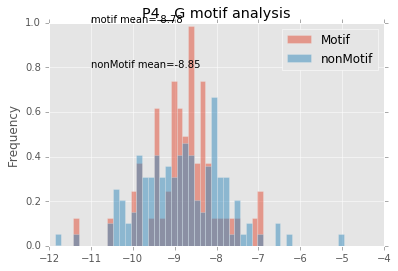

In [388]:
motif,nonMotif,motifName=seperateMotifAndNonMotif('P4__G',data,'TC')
histOfMotfAndNonMotif(motif,nonMotif,motifName)

More data about the motifs that could give an idea about other factors influencing the substitution rates other than the motifs

In [385]:

def parseSeq(seqLocation,codingStart,codingEnd):
    fasta_sequences = SeqIO.parse(open(seqLocation),'fasta')
    for fasta in fasta_sequences:
        consensus= fasta.seq[codingStart:codingEnd]
        return consensus

def isSynMutation(seq,kmer,offset,k=5):
    originalSeq=str(seq)
    mutatedSeq=str(seq)  
    mutatedSeqList=list(mutatedSeq)
    mutatedSeqList[offset-k//2:offset+k//2+1]=list(kmer)
    mutatedSeq="".join(mutatedSeqList)
    return translate(originalSeq)==translate(mutatedSeq)
    
def checkMotiflocations(seq,motif,mutationType):
    locations=[]
    motif=featureToMotiff(motif,mutationType,toString=False)
    k=len(motif)
    #print motif
    allIndices=set([i for i in range(k)])
    freeIndices=set([i for i, x in enumerate(motif) if x == "X"])
    #print freeIndices
    checkIndices=list(allIndices-freeIndices)
    #print checkIndices
    for i in range(k//2,len(seq)-k//2):
        isMotif=True
        compared=list(seq[i-k//2:i+k//2+1])
        #print compared
        for position in checkIndices:
            #print (compared[position],motif[position])
            if compared[position]!=motif[position]:
                isMotif=False
                break
        comparedAfterMutation=compared
        comparedAfterMutation[k//2]=mutationType[1]
        if (isMotif and isSynMutation(seq,comparedAfterMutation,i)):
            locations.append(i)
    return locations

def is4FoldDegenerate(seq,location,k=5):
    compared=list(seq[location-k//2:location+k//2+1])
    for nuc in NUCS:
        compared[k//2]=nuc
        if not(isSynMutation(seq,compared,location)):
            return False
    return True


def iterateOverLocationsList(function,seq,locations,k=5):
    resList=[]
    for location in locations:
        if function(seq,location):
            resList.append(location)
    return resList
            
def hyperGeoTest(M,n,locations,TrueLocations):
    rv = hypergeom(M, n, locations)
    return rv.pmf(TrueLocations)

def checkHyperGeometricForAllMotifs(motifTable,function,M,n,seq,thrashold=0.05):
    sigHG={}
    mutations=motifTable.columns
    for mt in mutations:
        lenn=len(motifTable[mt])
        tableByMt=motifTable[mt]
        for i in range(lenn):
            cellMotifs=tableByMt[i]
            if cellMotifs!="":
                for motif in cellMotifs:
                    #print motif
                    allLocations=checkMotiflocations(seq,motif,mt)
                    #print len(allLocations)
                    trueLocations=iterateOverLocationsList(function,seq,allLocations)
                    #print len(trueLocations)
                    pvalue=hyperGeoTest(M,n,len(allLocations),len(trueLocations))
                    #print pvalue
                    if (featureToMotiff(motif,mt),mt) in sigHG.keys():
                        continue
                    if (pvalue < thrashold):
                        sigHG[(featureToMotiff(motif,mt),mt)]=pvalue
    return pd.DataFrame(sigHG.items(),columns=['motif_mutationType','HG test PV'])

<h3>4-fold Degenerate sites enrichment</h3>

We want to check the if there is any kind of enrichment for 4-fold degenerate site. in order to do this we will preform a HG test when $n=994$ is the number of 4-fold degenerate sites within the coding region and $M=2345$ possible sites of synonymous mutation.

<b>There appears to be an significant large number of 4-fold degenerate sites in many of the motif we found as having an effect on mutation rate</b>

In [389]:
cons=parseSeq(r'C:\Users\Guyling1\ContextProject\AggarwalaPaper\sabin2.full_genome.U882C.A2973G.C4905U.C5526U.fasta',747,7638)
checkHyperGeometricForAllMotifs(rawMotifSummary,is4FoldDegenerate,2345,994,cons)

,motif_mutationType,HG test PV
0,"(AGGXC, GA)",2.092757e-02
1,"(GXTTG, TA)",3.217076e-02
2,"(AXATA, AC)",3.217076e-02
3,"(XXTAX, TC)",1.274725e-02
4,"(GCCXX, CG)",7.755594e-16
5,"(XCAXX, AC)",6.681771e-53
6,"(CAATX, AG)",3.639374e-02
7,"(XXATG, AT)",4.712874e-02
8,"(XXTAA, TC)",4.990953e-02
9,"(XTAGX, AG)",3.247597e-02
